TRAV and Clonotype Analysis for single cell RNA sequencing data for SKG mice Rheumatoid Arthritis Project

Last Updated on: August 11, 2021

# Import Packages

In [1]:
import sys

#Import libraries
#import scanorama
import time
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata as ad
from scipy.sparse import csr_matrix
import logging
#from skbio.stats.composition import clr

#import doubletdetection
import matplotlib.pyplot as plt
import matplotlib.axes as axes
#import os
#For CLR of ADTs
import scipy
import scipy.stats
from sklearn.preprocessing import scale
import os
import copy
import itertools
import seaborn as sns
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)


sc.logging.print_versions() 
sc.settings.set_figure_params(dpi=300)


/wynton/home/ye/emccarthy/miniconda3/envs/scanpy_upd/lib/python3.8/site-packages/scanpy/api/__init__.py:3: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  warnings.warn(


scanpy==1.5.1 anndata==0.7.3 umap==0.4.3 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.7.1 leidenalg==0.8.0


/wynton/home/ye/emccarthy/miniconda3/envs/scanpy_upd/lib/python3.8/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [2]:
import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred'])

# Load TCR Data

In [2]:
#Load data
path = 'adata_object/'
adata_file = path + 'adata_only_T_cells.h5ad'
adata = sc.read(adata_file)
print("done")

done


In [7]:
#Load TCR
sample_list = pd.read_csv('data/sc_RNA_sample_sheet.csv', sep = ',')
sample_list['sample_names'] = [str(x) + '_' + y + '_' + z for x,y,z in zip(sample_list['mouse'],sample_list['genotype'],sample_list['GFP'])]
no_wells = sample_list.shape[0]

TCR_data = [None] * no_wells
barcode_counts = [None] * no_wells
sample_names = np.array(sample_list['TCR'])

path =  '/path/to/TCR/data/' #update path
TCR_files = [path + x + '.csv' for x in sample_names]

for index in range(len(TCR_files)):
    TCR_index = index + 0
    TCR_data[TCR_index] = pd.read_csv(TCR_files[index], sep = ',' )
    print("Original: ",len(np.unique(TCR_data[TCR_index]['barcode'])))
    barcodes = [x[0:18] for x in adata[adata.obs['batch'] == str(TCR_index)].obs.index]
    TCR_data[TCR_index] = TCR_data[TCR_index].loc[TCR_data[TCR_index]['barcode'].isin(barcodes)]
    print("After cell filtering: ",len(np.unique(TCR_data[TCR_index]['barcode'])))

    
    #CELLS WITH CDR3 AND JUST 1 TRA/TRB
    TCR_data[TCR_index] = TCR_data[TCR_index].loc[TCR_data[TCR_index]['cdr3'] != "None"]
    print("After CDR3 filtering: ",len(np.unique(TCR_data[TCR_index]['barcode'])))
    unique_barcodes_cells = np.unique(TCR_data[TCR_index]["barcode"])
    barcode_counts_all = {}
    for barcode in unique_barcodes_cells:
        TRA = np.sum(TCR_data[TCR_index][(TCR_data[TCR_index]["barcode"] == barcode)]["chain"] == "TRA")
        TRB = np.sum(TCR_data[TCR_index][(TCR_data[TCR_index]["barcode"] == barcode)]["chain"] == "TRB")
        Multi = np.sum(TCR_data[TCR_index][(TCR_data[TCR_index]["barcode"] == barcode)]["chain"] == "Multi")
        barcode_counts_all[barcode] =[TRA,TRB,Multi]
    
    #TCR_cells_csv[i] = TCR_csv_cells
    barcode_counts[TCR_index] = barcode_counts_all
    tra_trb_singles = len([num for num in list(barcode_counts_all.values()) if num[0] <= 2 and num[1] <= 1])
    print("After multiplet filtering: ", tra_trb_singles)
    barcodes_to_keep = [num[0] for num in list(barcode_counts_all.items()) if num[1][0] <= 2 and num[1][1] <= 1]
    print("After multiplet filtering: (same as above)", len(barcodes_to_keep))
    TCR_data[TCR_index] = TCR_data[TCR_index].loc[TCR_data[TCR_index]['barcode'].isin(barcodes_to_keep)]


    


Original:  11215
After cell filtering:  10992
After CDR3 filtering:  10992
After multiplet filtering:  9906
After multiplet filtering: (same as above) 9906
Original:  10704
After cell filtering:  10507
After CDR3 filtering:  10507
After multiplet filtering:  9538
After multiplet filtering: (same as above) 9538
Original:  13587
After cell filtering:  13408
After CDR3 filtering:  13408
After multiplet filtering:  11817
After multiplet filtering: (same as above) 11817
Original:  12146
After cell filtering:  12024
After CDR3 filtering:  12024
After multiplet filtering:  10963
After multiplet filtering: (same as above) 10963
Original:  11602
After cell filtering:  11380
After CDR3 filtering:  11380
After multiplet filtering:  10164
After multiplet filtering: (same as above) 10164
Original:  12460
After cell filtering:  12337
After CDR3 filtering:  12337
After multiplet filtering:  11149
After multiplet filtering: (same as above) 11149
Original:  14439
After cell filtering:  14295
After CDR3

In [99]:
import pickle
file_to_store = open("results/single_cell_RNA_seq/TCR/TCR_data.pickle", "wb")
pickle.dump(TCR_data, file_to_store)
file_to_store.close()

In [3]:
#To load object

import pickle
file_to_read = open("results/single_cell_RNA_seq/TCR/TCR_data.pickle", "rb")

TCR_data = pickle.load(file_to_read)

file_to_read.close()

# Add TRAV data to adata

In [8]:
barcode_v_gene_dict_all = {}
for i in range(len(TCR_data)):
    barcode_subset = adata[[x == str(i) for x in adata.obs['batch']]].obs.index
    barcode_subset = [x[:-2] for x in barcode_subset]
    TCR_subset = TCR_data[i][[x in barcode_subset for x in TCR_data[i]['barcode']]]
    TCR_subset = TCR_subset[TCR_subset['chain'] == 'TRA']
    df = TCR_subset.loc[:,['barcode', 'v_gene']].groupby(['barcode']).agg(lambda x: tuple(x)).applymap(list).reset_index()
    print(i, "Number of cells: ", len(np.unique(TCR_subset['barcode'])), "Number of TCRs: ", TCR_subset.shape[0], "Combined TCRs: ", df.shape[0])
    barcode_v_gene_dict = {y:z for y,z in zip([x + "-" + str(i) for x in df['barcode']],list(df['v_gene']))}
    barcode_v_gene_dict_all.update(barcode_v_gene_dict)


0 Number of cells:  8911 Number of TCRs:  10198 Combined TCRs:  8911
1 Number of cells:  8763 Number of TCRs:  9882 Combined TCRs:  8763
2 Number of cells:  10825 Number of TCRs:  12414 Combined TCRs:  10825
3 Number of cells:  10162 Number of TCRs:  11527 Combined TCRs:  10162
4 Number of cells:  9245 Number of TCRs:  10459 Combined TCRs:  9245
5 Number of cells:  10254 Number of TCRs:  11537 Combined TCRs:  10254
6 Number of cells:  11488 Number of TCRs:  13192 Combined TCRs:  11488
7 Number of cells:  8006 Number of TCRs:  9043 Combined TCRs:  8006


In [9]:
adata.obs['TRAV'] = [barcode_v_gene_dict_all.get(x, ['None']) for x in adata.obs.index]
adata.obs['TRAV'] = ['_'.join(x) for x in list(adata.obs['TRAV'])]

# Add TRBV data to adata

In [10]:
barcode_v_gene_dict_all_beta = {}
for i in range(len(TCR_data)):
    barcode_subset = adata[[x == str(i) for x in adata.obs['batch']]].obs.index
    barcode_subset = [x[:-2] for x in barcode_subset]
    TCR_subset = TCR_data[i][[x in barcode_subset for x in TCR_data[i]['barcode']]]
    TCR_subset = TCR_subset[TCR_subset['chain'] == 'TRB']
    print(i, "No barcodes with multiple TRBVs: ", len(np.unique(TCR_subset['barcode'])) == TCR_subset.shape[0])
    barcode_v_gene_dict = {y:z for y,z in zip([x + "-" + str(i) for x in TCR_subset['barcode']],list(TCR_subset['v_gene']))} #add batch data
    barcode_v_gene_dict_all_beta.update(barcode_v_gene_dict)

0 No barcodes with multiple TRBVs:  True
1 No barcodes with multiple TRBVs:  True
2 No barcodes with multiple TRBVs:  True
3 No barcodes with multiple TRBVs:  True
4 No barcodes with multiple TRBVs:  True
5 No barcodes with multiple TRBVs:  True
6 No barcodes with multiple TRBVs:  True
7 No barcodes with multiple TRBVs:  True


In [100]:
adata.obs['TRBV'] = [barcode_v_gene_dict_all_beta.get(x, 'None') for x in adata.obs.index]
adata.obs['TRBV'] = [str(x) for x in adata.obs['TRBV']]

# Add Clonotype data to adata

In [12]:
barcode_clonotype_dict_all = {}
for i in range(len(TCR_data)):
    barcode_subset = adata[[x == str(i) for x in adata.obs['batch']]].obs.index
    barcode_subset = [x[:-2] for x in barcode_subset]
    TCR_subset = TCR_data[i][[x in barcode_subset for x in TCR_data[i]['barcode']]]
    #TCR_subset = TCR_subset[TCR_subset['raw_clonotype_id'] == 'TRA']
    df = TCR_subset.loc[:,['barcode', 'raw_clonotype_id']].groupby(['barcode']).agg(lambda x: tuple(x)).applymap(list).reset_index()
    df.loc[:,"raw_clonotype_id_unique"] = [np.unique(x) for x in list(df['raw_clonotype_id'])]
    print(i, "Number of cells: ", len(np.unique(TCR_subset['barcode'])), "Number of unique clonotypes: ", np.sum([x != 'None' for x in np.unique(df.loc[:,"raw_clonotype_id_unique"])]))
    barcode_clonotype_dict = {y:z for y,z in zip([x + "-" + str(i) for x in df['barcode']],list(df['raw_clonotype_id_unique']))}
    barcode_clonotype_dict_all.update(barcode_clonotype_dict)

0 Number of cells:  9906 Number of unique clonotypes:  9802
1 Number of cells:  9538 Number of unique clonotypes:  9484
2 Number of cells:  11817 Number of unique clonotypes:  11616
3 Number of cells:  10963 Number of unique clonotypes:  10932
4 Number of cells:  10164 Number of unique clonotypes:  10110
5 Number of cells:  11149 Number of unique clonotypes:  10987
6 Number of cells:  12607 Number of unique clonotypes:  12516
7 Number of cells:  8740 Number of unique clonotypes:  8602


In [14]:
adata.obs['clonotype'] = [barcode_clonotype_dict_all.get(x, 'None') for x in adata.obs.index]
adata.obs['clonotype'] = [str(x) for x in adata.obs['clonotype']]

In [101]:
path = 'adata_object/'
adata_file = path + 'adata_only_T_cells.h5ad'
adata.write(adata_file)

... storing 'TRBV' as categorical


# Gini Coefficient Analysis

In [85]:
adata_test = adata[adata.obs['clonotype'] != 'None']
print(adata_test)

View of AnnData object with n_obs × n_vars = 84740 × 1119
    obs: 'GFP', 'RBC', 'batch', 'genotype', 'mouse', 'n_counts', 'n_genes', 'percent_mito', 'platelet', 'louvain', 'leiden', 'GFP_category', 'subgroup', 'umap_density_subgroup', 'cell_types', 'S_score', 'G2M_score', 'phase', 'module_1', 'module_2', 'module_3', 'module_4', 'module_5', 'module_6', 'TRAV', 'TRBV', 'clonotype'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcodes', 'genes', 'leiden', 'louvain', 'neighbors', 'pca', 'rank_genes_groups', 'raw_counts', 'umap_density_subgroup_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [90]:

gini_dict = {}
for sample in np.unique(adata_test.obs['batch']):
    for cell_type in np.unique(adata_test.obs['cell_types']):
        adata_sample = adata_test[adata_test.obs['batch'] == sample]
        subgroup = np.unique(adata_sample.obs['subgroup'])[0]
        mouse = np.unique(adata_sample.obs['mouse'])[0]
        adata_sample = adata_sample[adata_sample.obs['cell_types'] == cell_type]
        total_cells = adata_sample.shape[0]
        if total_cells == 0:
            gini_dict[sample+cell_type] = [float('nan'), cell_type, total_cells, subgroup, mouse, sample]
        else:
       
            frequency = list(np.unique(adata_sample.obs['clonotype'], return_counts = True)[1])
            frequency.sort()
            frequency = frequency/np.sum(frequency)
            cum_freq = [np.sum(frequency[:i+1]) for i in list(range(len(frequency)))]
            cum_freq = [0] + cum_freq
            cum_prop = np.linspace(0,1,len(cum_freq))
      
            b_area = 0
            for i in range(len(frequency)):
                area = (cum_prop[i+1] - cum_prop[i])*(cum_freq[i+1] + cum_freq[i])/2
                b_area = b_area + area
            gini_cluster = (0.5-b_area)/0.5
            gini_dict[sample+cell_type] = [gini_cluster, cell_type, total_cells, subgroup, mouse]
          

In [91]:
gini_info = pd.DataFrame.from_dict(gini_dict)

In [92]:
gini_info.index = ["Gini Coefficient", "Cluster #", "Total Cells","Subgroup", "Mouse"]

In [94]:
gini_info.T.to_csv('results/single_cell_RNA_seq/TCR/data_S8_gini_coefficients.csv')

# Barplot paired TCR coverage

In [105]:
height = list()
for cluster in np.unique(adata_test.obs['cell_types']):
    adata_subset_cluster = adata_test[[x == cluster for x in adata_test.obs['cell_types']]]
    no_cells = adata_subset_cluster.shape[0]
    #print(barcodes[0:10])
    barcodes = adata[[x == cluster for x in adata.obs['cell_types']]].shape[0]
    height = height + [no_cells/barcodes]
    print("Cluster ", cluster, no_cells/barcodes)

Cluster  0 0.8868145494626619
Cluster  1 0.8800238610096189
Cluster  2 0.8173519736842105
Cluster  3 0.8592948187386195
Cluster  4 0.8883584282041865
Cluster  5 0.8605729877216917
Cluster  6 0.8840484769079594
Cluster  7 0.9030154849225754
Cluster  8 0.5354659248956884


In [106]:
no_cells = adata_test.shape[0]
barcodes = adata.shape[0]
print("All cells ", no_cells/barcodes)

All cells  0.8553202656600117


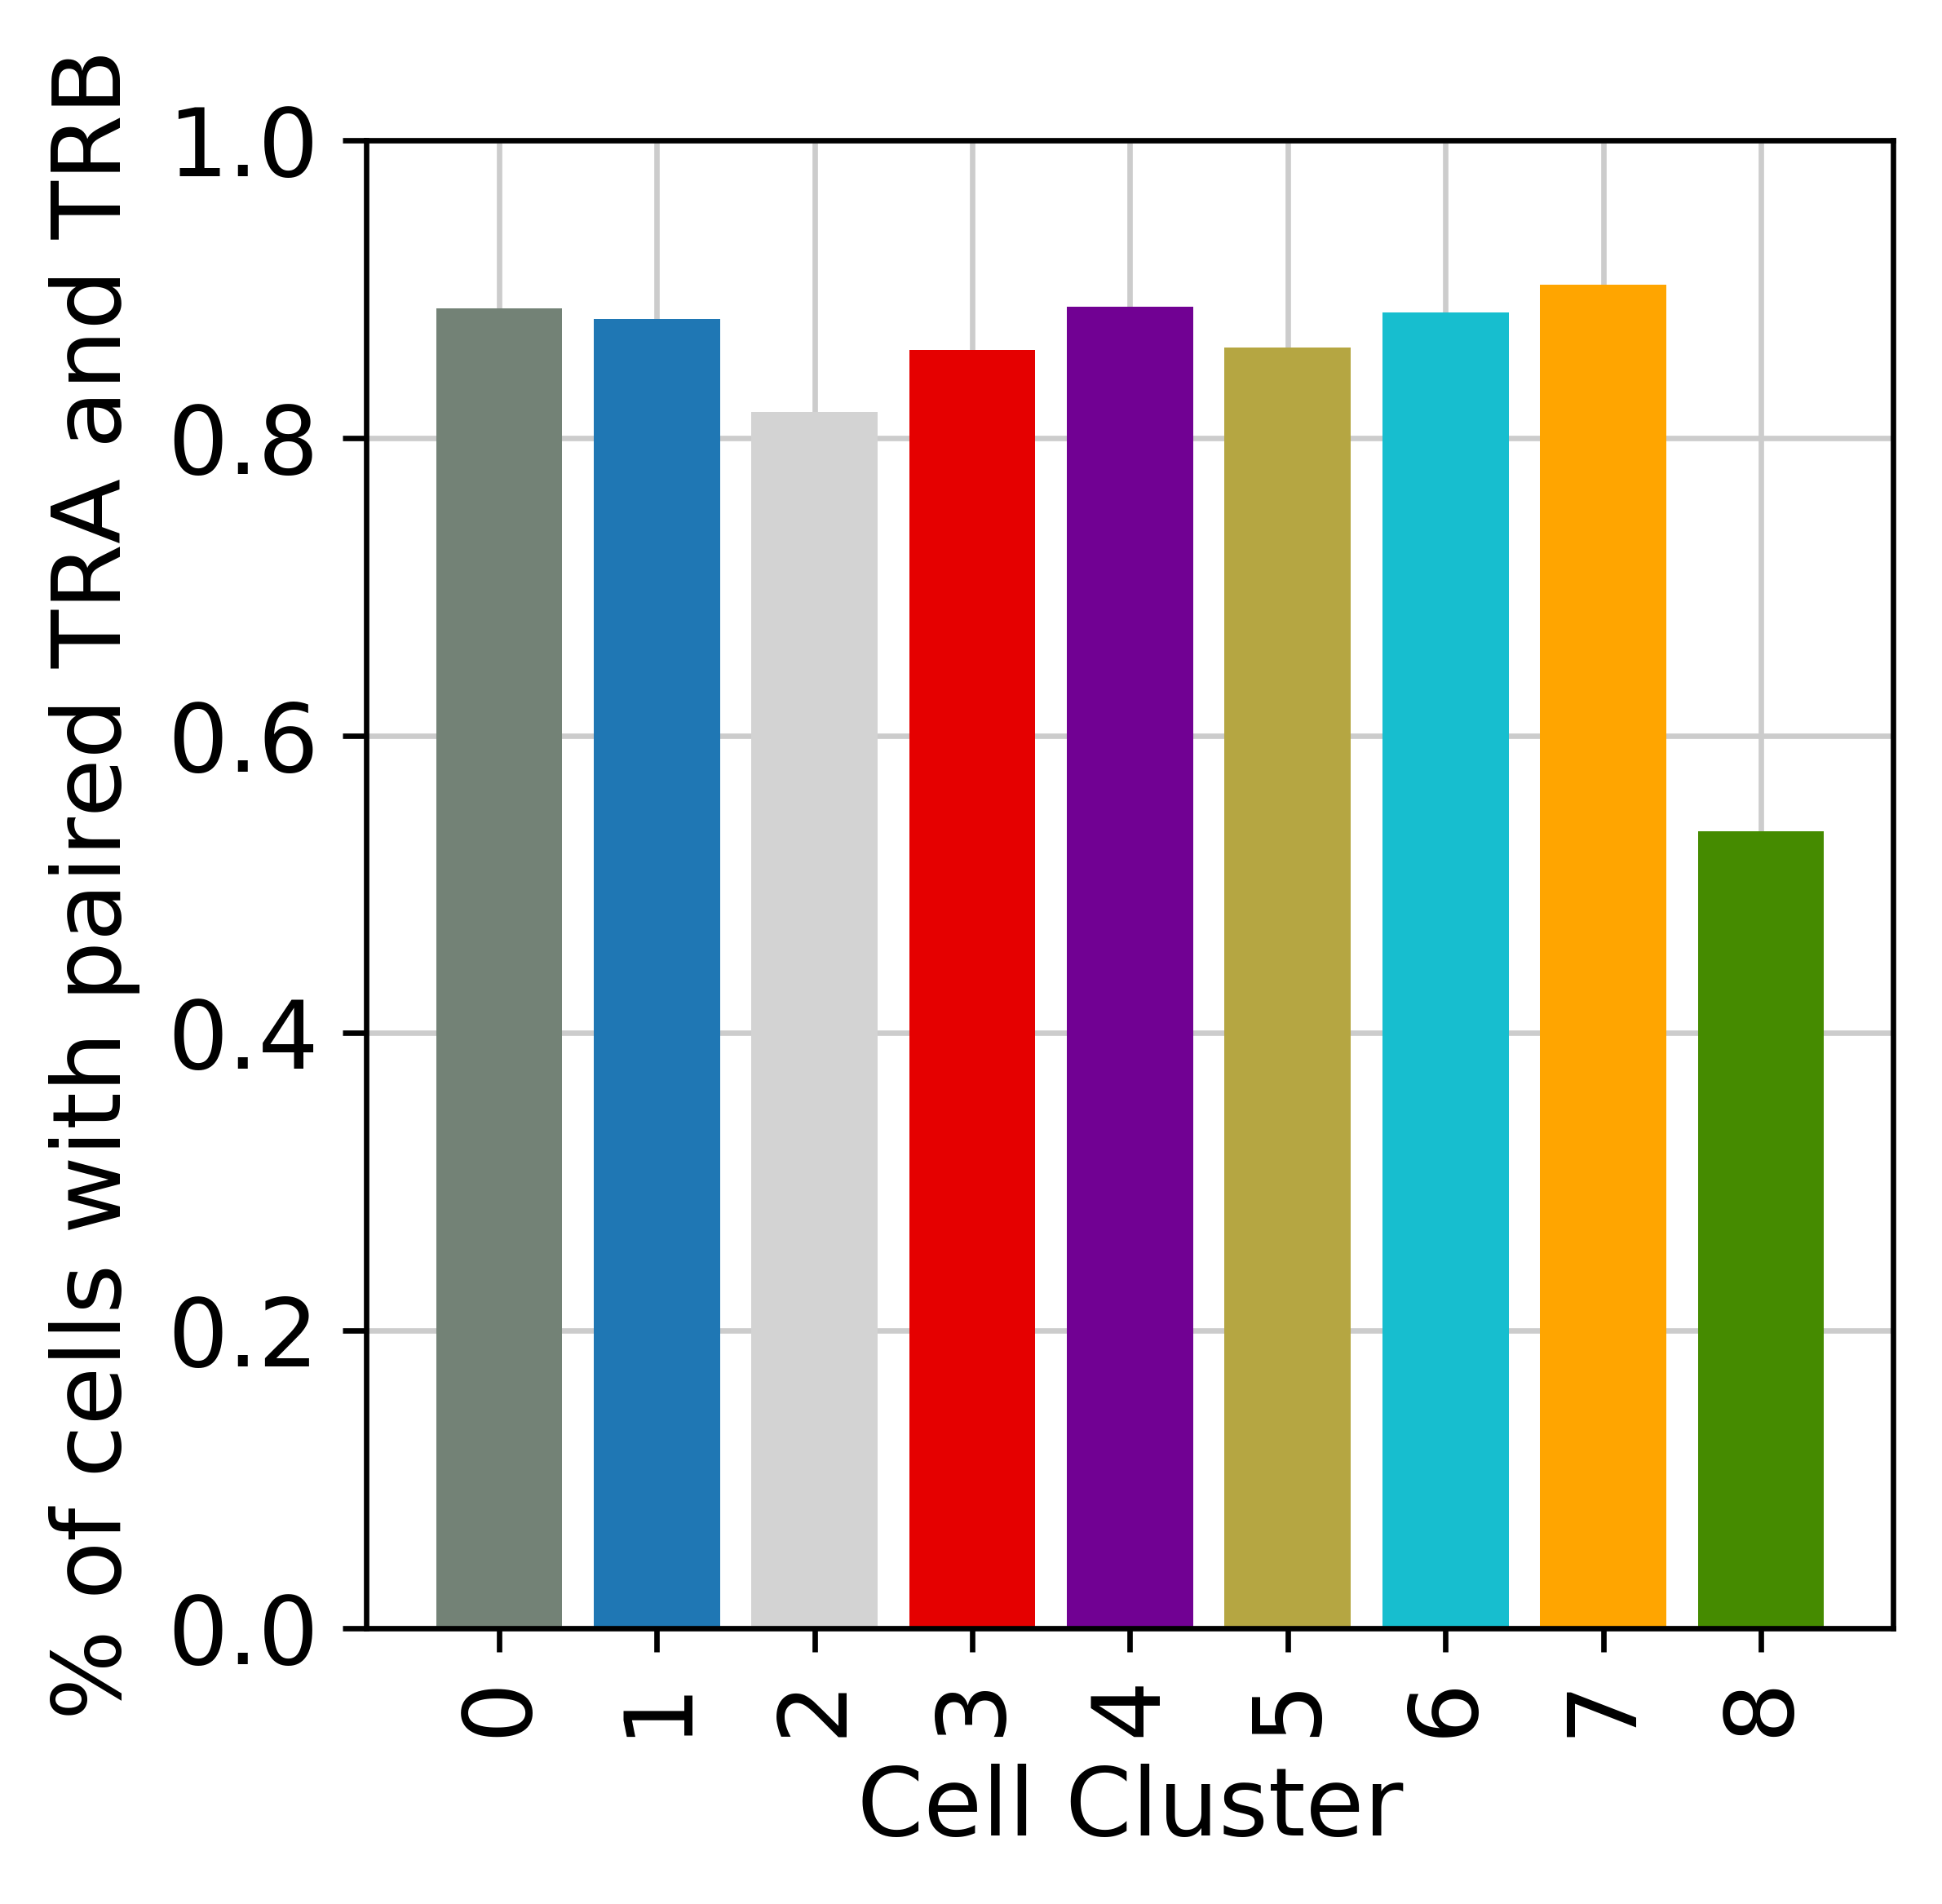

In [109]:
##Plot TCR
#file_prefix = "results/single_cell_RNA_seq/TCR"
height = height
bars = list(np.unique(adata_test.obs['cell_types']))
y_pos = np.arange(len(bars))
 
# Create bars
plt.figure()
plt.bar(y_pos, height, color = ['#738276', '#1F77B4','#d3d3d3','#e50000','#710193','#b5a642','#17becf','#ffa500' , '#458B00'] )
 
# Create names on the x-axis
plt.xticks(y_pos, bars, rotation='vertical')
#plt.title("% Paired ")
plt.ylabel("% of cells with paired TRA and TRB")
plt.xlabel("Cell Cluster")

plt.ylim(top=1)
#plt.savefig(file_prefix + "percent_pairing_for_cell_sub_types_by_subgroup.eps", format="eps")
# Show graphic
plt.show()
plt.close()

# Filter cells based on TRAV

In [17]:
adata

AnnData object with n_obs × n_vars = 99074 × 1119
    obs: 'GFP', 'RBC', 'batch', 'genotype', 'mouse', 'n_counts', 'n_genes', 'percent_mito', 'platelet', 'louvain', 'leiden', 'GFP_category', 'subgroup', 'umap_density_subgroup', 'cell_types', 'S_score', 'G2M_score', 'phase', 'module_1', 'module_2', 'module_3', 'module_4', 'module_5', 'module_6', 'TRAV', 'TRBV', 'clonotype'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcodes', 'cell_types_colors', 'genes', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'raw_counts', 'umap_density_subgroup_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [18]:
len(np.unique(adata.obs['TRAV']))

3007

In [4]:
adata_subset = adata[adata.obs['TRAV'] != 'None']

In [20]:
adata_subset

View of AnnData object with n_obs × n_vars = 77654 × 1119
    obs: 'GFP', 'RBC', 'batch', 'genotype', 'mouse', 'n_counts', 'n_genes', 'percent_mito', 'platelet', 'louvain', 'leiden', 'GFP_category', 'subgroup', 'umap_density_subgroup', 'cell_types', 'S_score', 'G2M_score', 'phase', 'module_1', 'module_2', 'module_3', 'module_4', 'module_5', 'module_6', 'TRAV', 'TRBV', 'clonotype'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcodes', 'cell_types_colors', 'genes', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'raw_counts', 'umap_density_subgroup_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [21]:
len(np.unique(adata_subset.obs['TRAV']))

3006

# Calculate double TRA frequency

In [23]:
#WThi, WTlo, SKGhi, SKGlo

subtype_loc = {"WT_High":[2,6], "WT_Low":[3,7], "SKG_High":[0,4], "SKG_Low":[1,5]}

TCR_alpha_var = {}
gene_list_TRA = list()
barcodes = list()
for i in range(len(TCR_data)):
    adata_subset_2 = adata_subset[[x == str(i) for x in adata_subset.obs['batch']]]
    genes, counts = np.unique(adata_subset_2.obs['TRAV'], return_counts = True)
    TCR_alpha_var[i] =  dict(zip(genes, counts)) 
    gene_list_TRA = gene_list_TRA + list(genes)
    barcode_length = adata_subset_2.shape[0]
    barcodes = barcodes + [barcode_length]

gene_list_TRA = sorted(list(set(gene_list_TRA)))    

gene_dictionary_TRA = {}
for gene in gene_list_TRA:
    counts_for_genes = [0,0,0,0,0,0,0,0]
    for i in range(len(TCR_data)): 
        #subtype = adata[adata.obs['batch'] == str(i)].obs['subgroup'][0]
        counts_for_genes[i] = TCR_alpha_var[i].get(gene,0) 
    gene_dictionary_TRA[gene] = counts_for_genes

In [24]:
double_genes = np.array(gene_list_TRA)[["_" in x for x in gene_list_TRA]]
all_values_1 = list()
all_values = list()
for gene in double_genes:
    values = [x/y*100 for x,y in zip(gene_dictionary_TRA[gene],barcodes)]
    all_values_1 = all_values_1 + values
    if (values[0] >0 and values[4] > 0) or (values[1] >0 and values[5] > 0) or (values[2] >0 and values[6] > 0) or (values[3] >0 and values[7] > 0):
        all_values = all_values + values

In [25]:
np.max(all_values)

0.08856524306238929

In [26]:
np.max(all_values_1)

0.08856524306238929

In [27]:
np.where([x == 0.08856524306238929 for x in all_values])

(array([891]),)

In [28]:
891/8

111.375

In [29]:
gene_dictionary_TRA[double_genes[111]]

[0, 0, 0, 0, 0, 0, 1, 1]

In [30]:
barcodes

[8911, 8763, 10825, 10162, 9245, 10254, 11488, 8006]

# Filter cells based on TRAV (cont.)

In [5]:
adata_subset = adata_subset[["_" not in x for x in list(adata_subset.obs['TRAV'])]]

In [32]:
adata_subset

View of AnnData object with n_obs × n_vars = 67056 × 1119
    obs: 'GFP', 'RBC', 'batch', 'genotype', 'mouse', 'n_counts', 'n_genes', 'percent_mito', 'platelet', 'louvain', 'leiden', 'GFP_category', 'subgroup', 'umap_density_subgroup', 'cell_types', 'S_score', 'G2M_score', 'phase', 'module_1', 'module_2', 'module_3', 'module_4', 'module_5', 'module_6', 'TRAV', 'TRBV', 'clonotype'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcodes', 'cell_types_colors', 'genes', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'raw_counts', 'umap_density_subgroup_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [33]:
len(np.unique(adata_subset.obs['TRAV']))

92

In [34]:
#freq of double TRAs of all cells

(77654-67056)/99074

0.10697054726769889

In [35]:
#freq of double TRAs of cells with assigned TRA
(77654-67056)/77654

0.13647719370541117

# Plot TRAV abundance by subgroup

In [74]:
def barplot_grouped_obs_cat(adata, obs_cat, group_names, grouping_dict, sample,order_string, palette, order, fontsize = 10, x_label = None, y_label = None, title = None, save_file = None, file_save_prefix = None, file_format = "png", legend = False, addition = ""):
    #adata  = adata object
    #obs_cat = category that you will create counts of for each sample
    #group_names = unique names of categories in obs_cat in order you want them to appear
    #grouping_dict = dictionary between sample names and grouping for box plot
    #sample = name of .obs category that holds the sample names
    all_values = dict()
    for sample_name in np.unique(adata.obs[sample]):
        names, counts = np.unique(adata[adata.obs[sample] == sample_name].obs[obs_cat], return_counts = True)
        counts = counts/np.sum(counts)*100
        values = dict(zip(names, counts))
        sample_name_values = list()
        for name in group_names:
            sample_name_values = sample_name_values + [values.get(name, 0)]
        all_values[sample_name] = sample_name_values
        #print(sample_name)
    df_all = pd.DataFrame(all_values)
    df_all.index = group_names
    
    df_all = df_all.T
    df_all["sample"] = df_all.index
    df_all["group"] = [grouping_dict[x] for x in df_all.index]
    df_all = df_all.set_index(['sample', 'group'])
    b = df_all.unstack().mean(0)
    b = pd.DataFrame(b)
    b = b.reset_index()
    b.columns = [obs_cat, 'group','Abundance']
    if obs_cat == 'leiden':
        b[obs_cat] = [int(x) for x in b[obs_cat]]
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(8, 11.7/5)
    g = sns.barplot(x=obs_cat, y='Abundance', hue="group",palette = palette, order = order, data=b, hue_order = order_string, ax = ax)
    ax.set(yscale="log")
    plt.xticks(rotation = 90, fontsize = fontsize)
    if x_label != None:
        plt.xlabel(x_label, fontsize = 10)
    if title != None:
        plt.title(title, fontsize = 10)
    if y_label != None:
        plt.ylabel(y_label, fontsize = 10)
   
    #plt.title(score_name, fontsize = 10)
    plt.yticks(fontsize = 10)
    if not legend:
        g.legend_.remove()
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if save_file:
        plt.savefig(file_save_prefix + "fig_4_TCR_TRA_summary_barplot"+ addition +"."+file_format, format=file_format, dpi = 300, bbox_inches = "tight")
    plt.show()
    return b

In [58]:
np.unique(adata_subset.obs['TRAV'])

array(['TRAV1', 'TRAV10', 'TRAV10D', 'TRAV10N', 'TRAV11', 'TRAV12-1',
       'TRAV12-3', 'TRAV12D-1', 'TRAV12D-2', 'TRAV12D-3', 'TRAV12N-1',
       'TRAV12N-2', 'TRAV13-1', 'TRAV13-2', 'TRAV13-4-DV7', 'TRAV13D-1',
       'TRAV13D-2', 'TRAV13D-3', 'TRAV13D-4', 'TRAV13N-3', 'TRAV13N-4',
       'TRAV14-1', 'TRAV14-2', 'TRAV14-3', 'TRAV14D-1', 'TRAV14D-2',
       'TRAV14D-3-DV8', 'TRAV14N-1', 'TRAV14N-2', 'TRAV14N-3',
       'TRAV15-1-DV6-1', 'TRAV15-2-DV6-2', 'TRAV15D-1-DV6D-1',
       'TRAV15D-2-DV6D-2', 'TRAV15N-1', 'TRAV16D-DV11', 'TRAV16N',
       'TRAV17', 'TRAV18', 'TRAV19', 'TRAV2', 'TRAV21-DV12', 'TRAV23',
       'TRAV3-1', 'TRAV3-3', 'TRAV3-4', 'TRAV3N-3', 'TRAV4-2', 'TRAV4-3',
       'TRAV4-4-DV10', 'TRAV4D-4', 'TRAV4N-4', 'TRAV5-1', 'TRAV5D-4',
       'TRAV5N-4', 'TRAV6-1', 'TRAV6-2', 'TRAV6-3', 'TRAV6-4', 'TRAV6-5',
       'TRAV6-6', 'TRAV6-7-DV9', 'TRAV6D-3', 'TRAV6D-4', 'TRAV6D-5',
       'TRAV6D-7', 'TRAV6N-5', 'TRAV6N-6', 'TRAV6N-7', 'TRAV7-1',
       'TRAV7-2', 'TRAV7-3',

In [103]:
#WThi, WTlo, SKGhi, SKGlo

subtype_loc = {"WT_High":[2,6], "WT_Low":[3,7], "SKG_High":[0,4], "SKG_Low":[1,5]}

TCR_alpha_var = {}
gene_list_TRA = list()
barcodes = list()
for i in range(len(TCR_data)):
    adata_subset_2 = adata_subset[[x == str(i) for x in adata_subset.obs['batch']]]
    genes, counts = np.unique(adata_subset_2.obs['TRAV'], return_counts = True)
    TCR_alpha_var[i] =  dict(zip(genes, counts)) 
    gene_list_TRA = gene_list_TRA + list(genes)
    barcode_length = adata_subset_2.shape[0]
    barcodes = barcodes + [barcode_length]

gene_list_TRA = sorted(list(set(gene_list_TRA)))    

gene_dictionary_TRA = {}
for gene in gene_list_TRA:
    counts_for_genes = [0,0,0,0,0,0,0,0]
    for i in range(len(TCR_data)): 
        #subtype = adata[adata.obs['batch'] == str(i)].obs['subgroup'][0]
        counts_for_genes[i] = TCR_alpha_var[i].get(gene,0) 
    gene_dictionary_TRA[gene] = counts_for_genes

In [104]:
barcodes

[7624, 7644, 9236, 8797, 8031, 8971, 9784, 6969]

In [45]:
skg_diff = list()
value_avg = list()
subgroup_presence = list()
two_mice_present  = list()
#Create ordering for gene list
for gene in list(gene_dictionary_TRA.keys()):

    labels = ["SKG_High","SKG_Low","WT_High", "WT_Low","SKG_High","SKG_Low","WT_High", "WT_Low"]
    values = [x/y*100 for x,y in zip(gene_dictionary_TRA[gene],barcodes)]
    skg_mean = np.mean([values[0]-values[1], values[4]-values[5]])

    skg_diff = skg_diff +[skg_mean]
    value_avg = value_avg + [np.mean(values)]
    #present in at least two mice of the same genotype
    subgroup_presence = subgroup_presence + [(values[0] >0 and values[4] > 0) or (values[1] >0 and values[5] > 0) or (values[2] >0 and values[6] > 0) or (values[3] >0 and values[7] > 0)]

    two_mice_present = two_mice_present + [np.sum([x>0 for x in values]) >= 2]

In [46]:
gene_list = pd.DataFrame.from_dict({"genes":list(gene_dictionary_TRA.keys()), "mean":skg_diff, "avg":value_avg, "subgroup": subgroup_presence, "two_mice": two_mice_present })

In [47]:
gene_order_2 = list(gene_list[gene_list['subgroup'] == True].sort_values(by = "avg")['genes'])

In [49]:
len(gene_order_2)

75

In [50]:
genes = list(gene_list[gene_list['subgroup'] == True]['genes'])

In [51]:
genes_to_keep = genes

In [52]:
len(genes_to_keep)

75

In [53]:
len(genes)

75

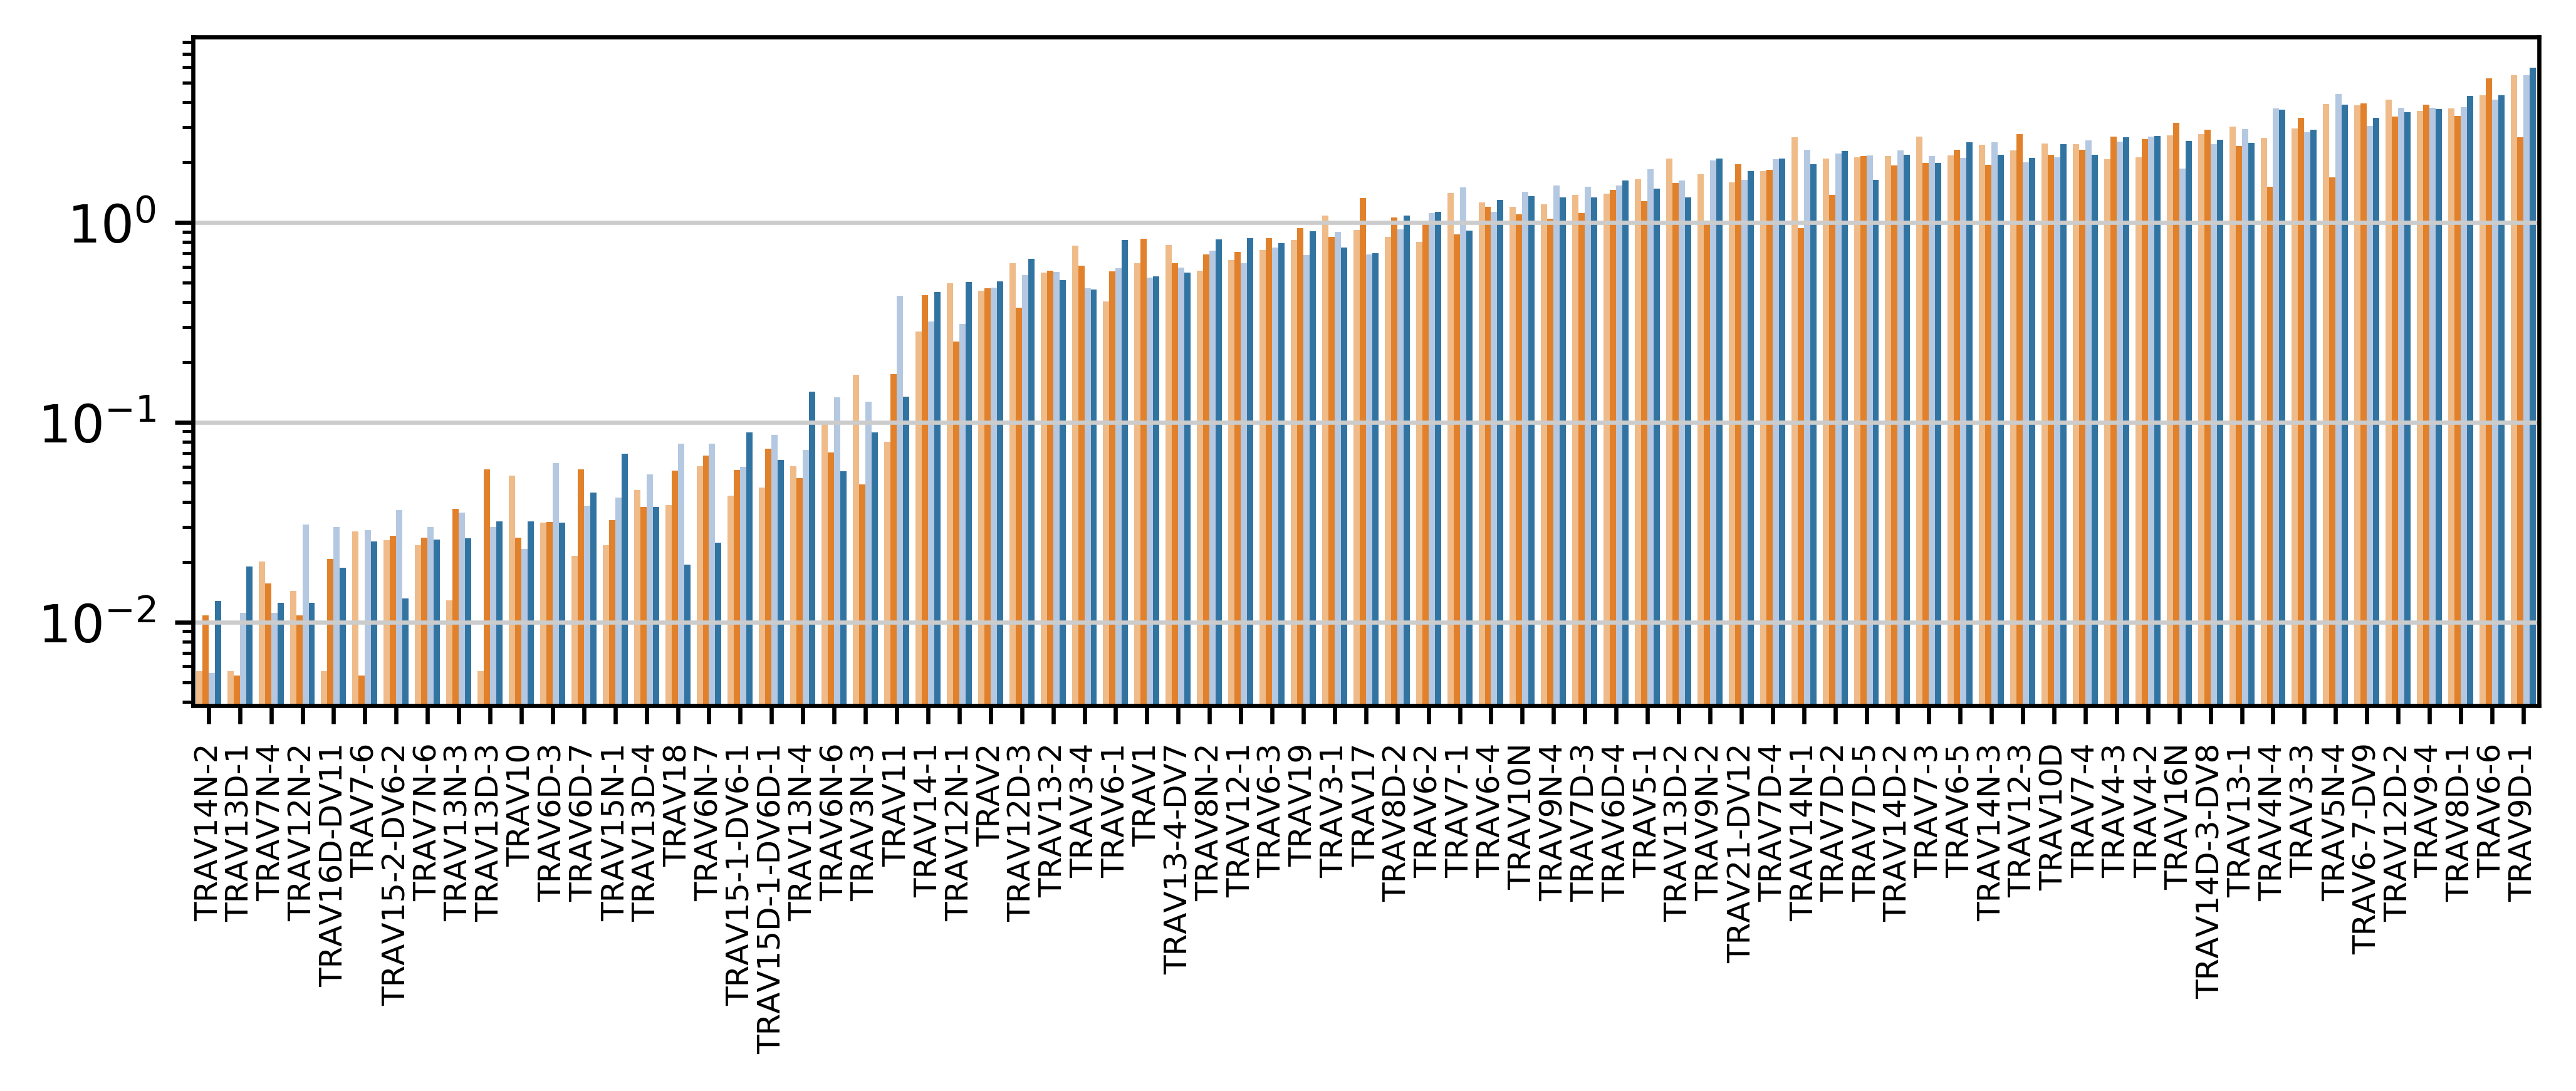

In [37]:
#Log scale
#palette = sns.color_palette(["#c77cff","#00bfc4","#7cae00","#f8766d"])
palette = sns.color_palette(["#ffbb78","#ff7f0e","#aec7e8","#1f77b4"])
#file_prefix = 
df = barplot_grouped_obs_cat(adata_subset, 'TRAV', list(np.unique(adata_subset.obs['TRAV'])), mouse_group_dict , 'batch', ["WT_Low","WT_High","SKG_Low","SKG_High"], palette, gene_order_2, fontsize = 6, x_label = "", y_label = "")#, save_file = True, file_save_prefix = file_prefix, file_format = 'svg')


# TRAV diff between SKG High and SKG Low

In [54]:
import scipy
from scipy import stats
gene_relative_delta = {}
for gene in genes:

    labels = ["SKG_High","SKG_Low","WT_High", "WT_Low","SKG_High","SKG_Low","WT_High", "WT_Low"]
    values = [x/y*100 for x,y in zip(gene_dictionary_TRA[gene],barcodes)]
    skg_mean = np.mean([values[0],values[4]])
    wt_mean = np.mean([values[2],values[6]])
    t_statistic = stats.ttest_rel([values[x] for x in [0,4]], [values[x] for x in [1,5]])[0]
    p_value = stats.ttest_rel([values[x] for x in [0,4]], [values[x] for x in [1,5]])[1]

    gene_relative_delta[gene] = [p_value, skg_mean, wt_mean, skg_mean > wt_mean, t_statistic]
    
import statsmodels.stats.multitest
adj_p_values = statsmodels.stats.multitest.fdrcorrection([x[0]/2 for x in list(gene_relative_delta.values())])[1]


In [40]:
scipy.__version__

'1.4.1'

In [41]:
statsmodels.__version__

'0.11.1'

In [55]:
nr4a1_genes = pd.DataFrame.from_dict(gene_relative_delta)
nr4a1_genes.index = ["Paired p value","Mean SKG High", "Mean WT High", "SKG High > WT High?", "t statistic"]
nr4a1_genes.loc["Paired p value",:] = [x/2 for x in list(nr4a1_genes.loc["Paired p value",:])]
nr4a1_genes.loc["Adj p value",:] = list(adj_p_values)


In [56]:
np.min(adj_p_values)

0.31672164824999294

In [57]:
color_list = list()
for x,y in zip(adj_p_values, [x[4] for x in list(gene_relative_delta.values())]):
    if x > 0.1:
        color_list = color_list +["#000000"]
    elif y > 0:
        color_list = color_list + ["#1f77b4"]
    else:
        color_list = color_list + ["#aec7e8"]

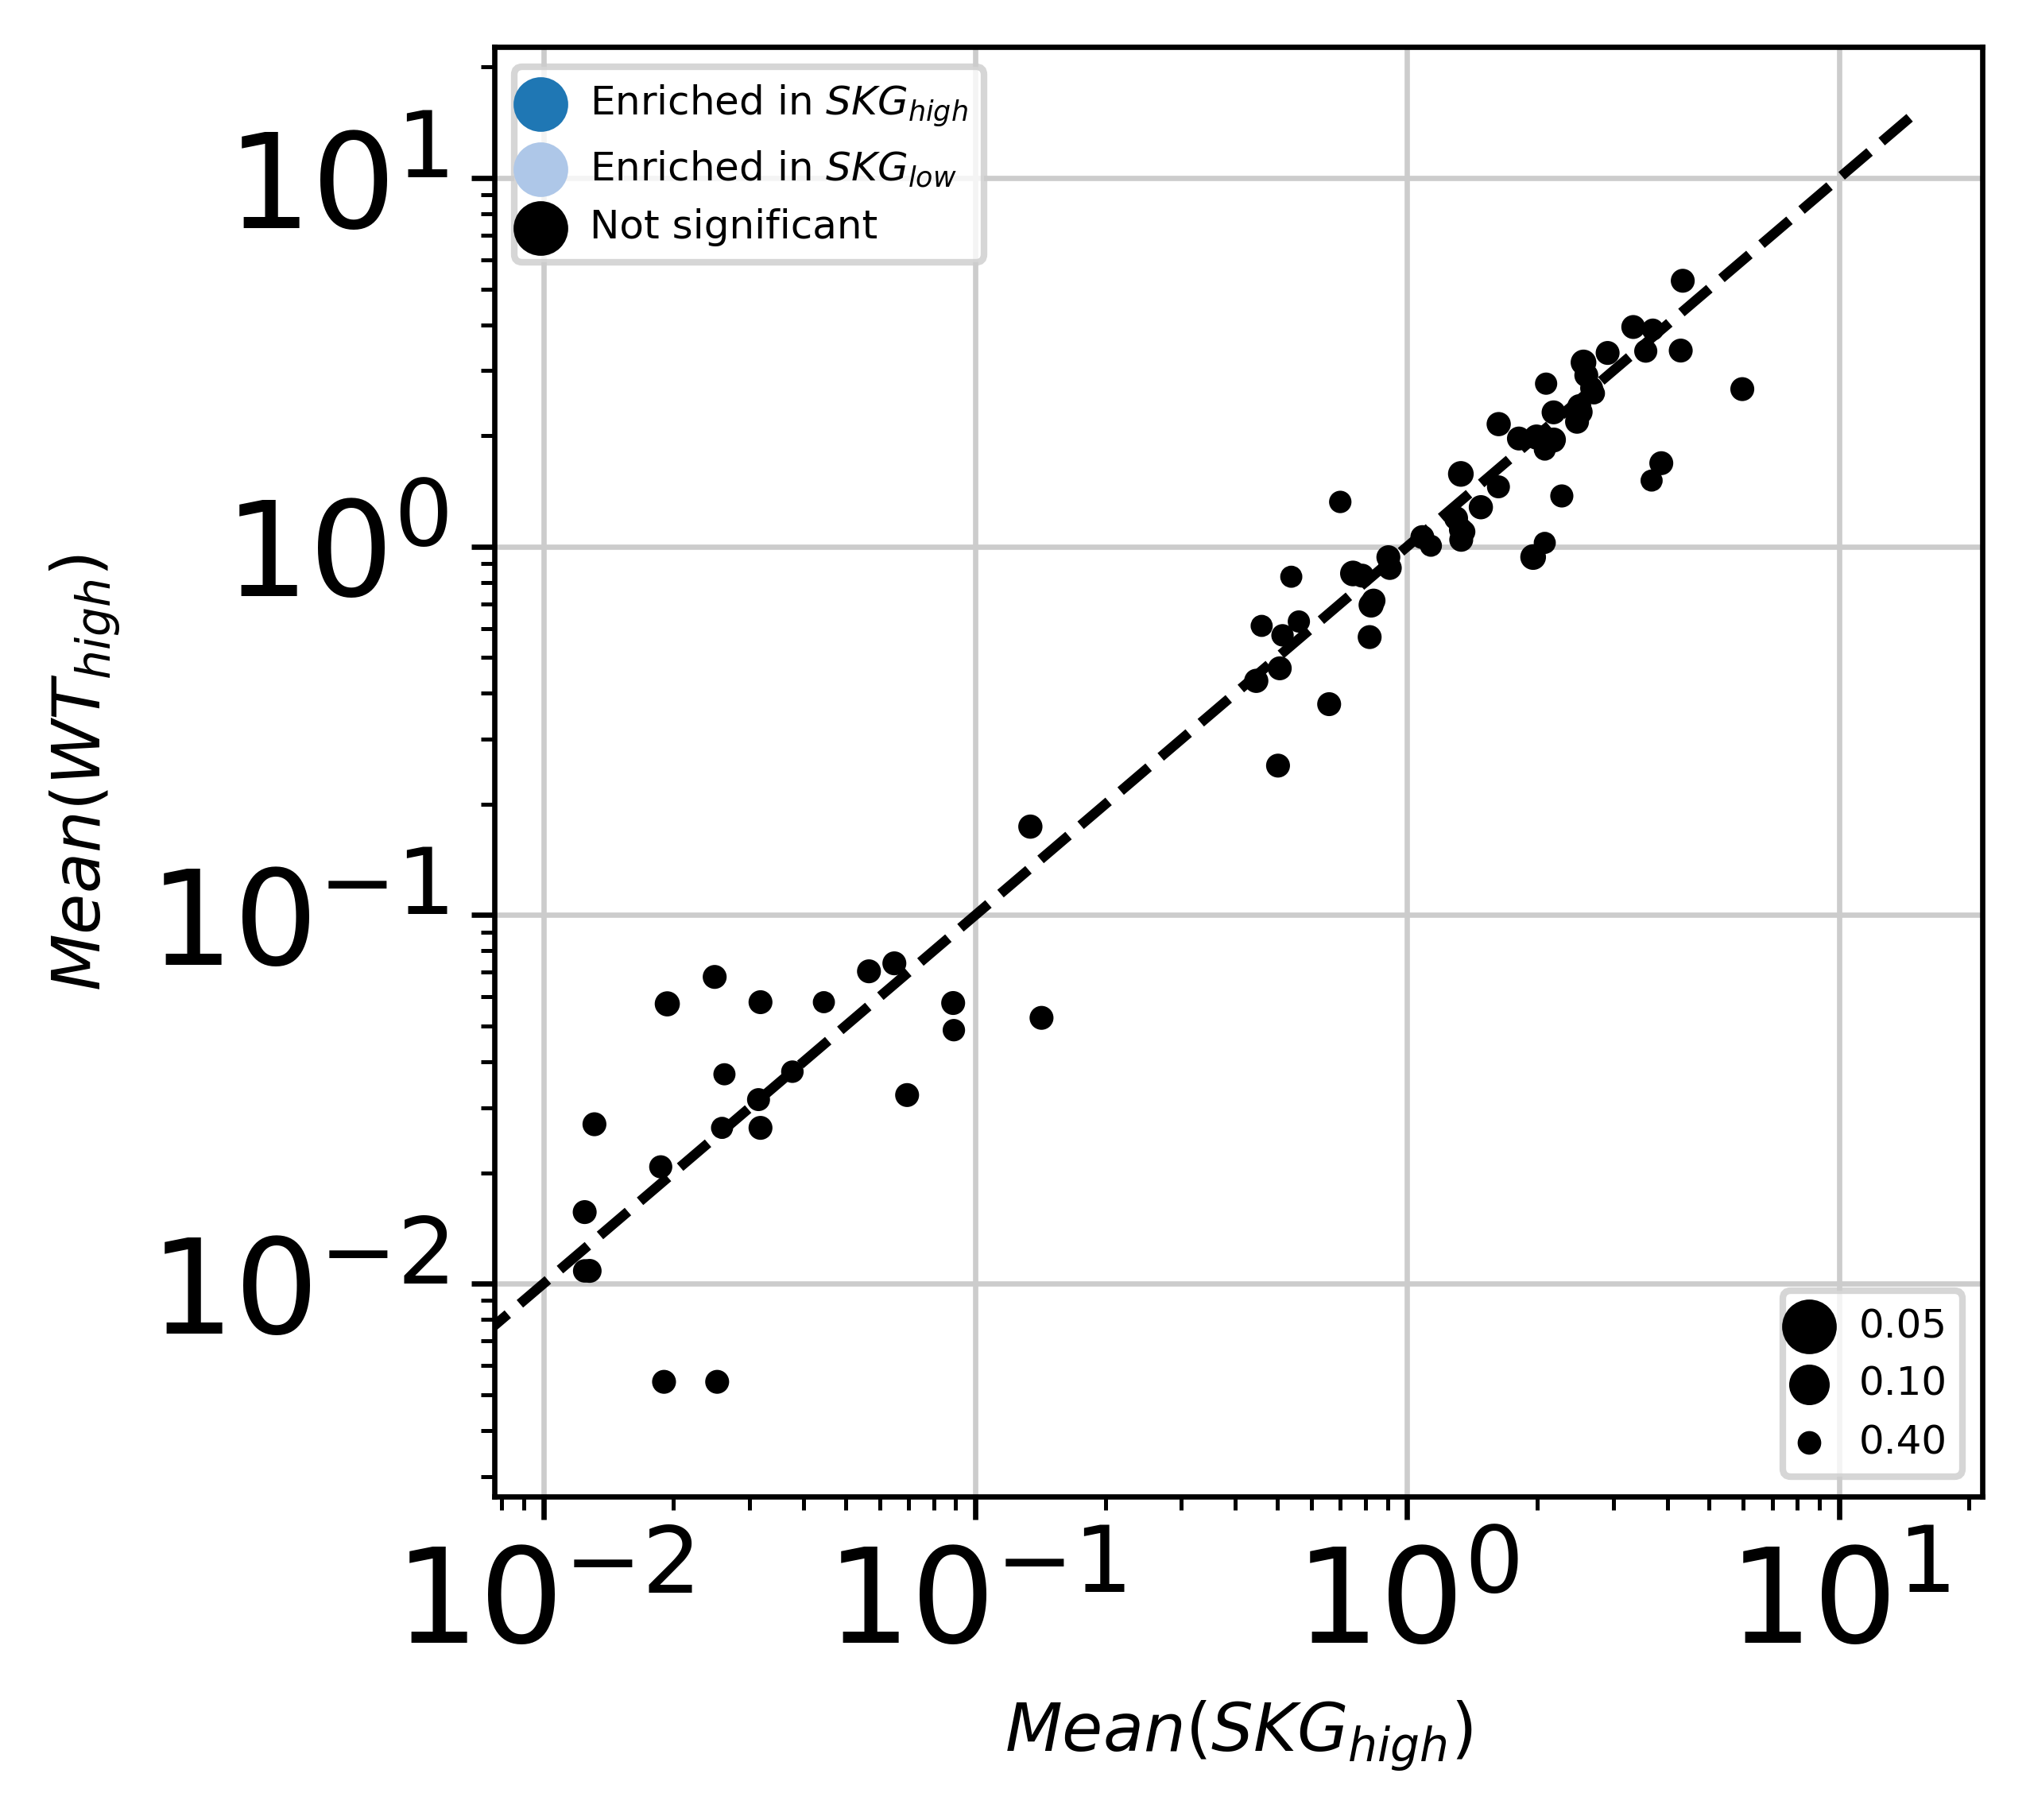

In [59]:
#file_save_prefix = 

plt.rc('axes', axisbelow=True)
extra_value = 20
division_value = 8
plt.scatter([x[1] for x in list(gene_relative_delta.values())], [x[2] for x in list(gene_relative_delta.values())],
            s = [(np.exp(-np.log(x))+extra_value/x)/division_value  for x in adj_p_values], edgecolors=color_list, color =  color_list)


plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel("$Mean(SKG_{high})$", size = 10)
plt.ylabel("$Mean(WT_{high})$", size = 10)
plt.plot([0,15],[0,15], color = 'black', linestyle = '--')
plt.xscale('log')
plt.yscale('log')

x = [i for i in [x[1] for x in list(gene_relative_delta.values())]]
y = [i for i in [x[2] for x in list(gene_relative_delta.values())]]
p = [i for i in adj_p_values]
labels = list(gene_relative_delta.keys())
bold_dic = {True:"bold", False:"normal"}
p_value_cutoff = 0.1
for i,txt in enumerate(labels):
    if ((p[i] < p_value_cutoff) and (x[i]> y[i] and color_list[i] == "#1f77b4")):
        plt.annotate(txt, (x[i], y[i]), size = 6, weight = "bold")
        #print(txt, p[i])
    elif (p[i] < p_value_cutoff):
        plt.annotate(txt, (x[i], y[i]), size = 6)
        #print(txt, p[i])


l1 = plt.scatter([],[], s=(np.exp(-np.log(0.05))+extra_value/0.05)/division_value, edgecolors="#1f77b4",  color = "#1f77b4")
l2 = plt.scatter([],[], s=(np.exp(-np.log(0.05))+extra_value/0.05)/division_value, edgecolors="#aec7e8",  color = "#aec7e8")
l3 = plt.scatter([],[], s=(np.exp(-np.log(0.05))+extra_value/0.05)/division_value, edgecolors='black',  color = "black")

labels = ["Enriched in $SKG_{high}$", "Enriched in $SKG_{low}$", "Not significant"]

leg = plt.legend([l1, l2, l3], labels, ncol=1, frameon=True, fontsize=6,#handlelength=2, 
                 loc = 2, #borderpad = 1.8,
handletextpad=1, #title='My Title'
                 scatterpoints = 1)

legend_color = 'black'
#l1 = plt.scatter([],[], s=np.exp(-np.log(0.01))+extra_value, edgecolors='black',  color = legend_color)
l1 = plt.scatter([],[], s=(np.exp(-np.log(0.05))+extra_value/0.05)/division_value, edgecolors='black',  color = legend_color)
l2 = plt.scatter([],[], s=(np.exp(-np.log(0.10))+extra_value/0.10)/division_value, edgecolors='black',  color = legend_color)
l3 = plt.scatter([],[], s=(np.exp(-np.log(0.4))+extra_value/0.4)/division_value, edgecolors='black',   color = legend_color)

labels = ["0.05", "0.10", "0.40"]

plt.legend([l1, l2, l3], labels, ncol=1, frameon=True, fontsize=6,#handlelength=2, 
                 loc = 4, #borderpad = 1.8,
handletextpad=1, #title='My Title'
                 scatterpoints = 1)

plt.gca().add_artist(leg)
#plt.savefig(file_save_prefix + "fig_4_TCR_TRA_all_cells_scatterplot_SKG_high_v_WT_high_labelled" + ".svg", format="svg")
plt.show()
plt.close()

# Analysis for T.4 Nr4a1 hi cluster

In [6]:
adata_subset_nr4a1_hi = adata_subset[adata_subset.obs['cell_types'] == '3']

In [7]:
#WThi, WTlo, SKGhi, SKGlo

subtype_loc = {"WT_High":[2,6], "WT_Low":[3,7], "SKG_High":[0,4], "SKG_Low":[1,5]}

TCR_alpha_var = {}
gene_list_TRA = list()
barcodes = list()
for i in range(len(TCR_data)):
    adata_subset_2 = adata_subset_nr4a1_hi[[x == str(i) for x in adata_subset_nr4a1_hi.obs['batch']]]
    genes, counts = np.unique(adata_subset_2.obs['TRAV'], return_counts = True)
    TCR_alpha_var[i] =  dict(zip(genes, counts)) 
    gene_list_TRA = gene_list_TRA + list(genes)
    barcode_length = adata_subset_2.shape[0]
    barcodes = barcodes + [barcode_length]

gene_list_TRA = sorted(list(set(gene_list_TRA)))    

gene_dictionary_TRA = {}
for gene in gene_list_TRA:
    counts_for_genes = [0,0,0,0,0,0,0,0]
    for i in range(len(TCR_data)): 
        #subtype = adata[adata.obs['batch'] == str(i)].obs['subgroup'][0]
        counts_for_genes[i] = TCR_alpha_var[i].get(gene,0) 
    gene_dictionary_TRA[gene] = counts_for_genes

In [8]:
skg_diff = list()
value_avg = list()
subgroup_presence = list()
two_mice_present  = list()
#Create ordering for gene list
for gene in list(gene_dictionary_TRA.keys()):

    labels = ["SKG_High","SKG_Low","WT_High", "WT_Low","SKG_High","SKG_Low","WT_High", "WT_Low"]
    values = [x/y*100 for x,y in zip(gene_dictionary_TRA[gene],barcodes)]
    skg_mean = np.mean([values[0]-values[1], values[4]-values[5]])

    skg_diff = skg_diff +[skg_mean]
    value_avg = value_avg + [np.mean(values)]
    #present in at least two mice of the same genotype
    subgroup_presence = subgroup_presence + [(values[0] >0 and values[4] > 0) or (values[1] >0 and values[5] > 0) or (values[2] >0 and values[6] > 0) or (values[3] >0 and values[7] > 0)]
    
    two_mice_present = two_mice_present + [np.sum([x>0 for x in values]) >= 2]

In [9]:
gene_list = pd.DataFrame.from_dict({"genes":list(gene_dictionary_TRA.keys()), "mean":skg_diff, "avg":value_avg, "subgroup": subgroup_presence, "two_mice": two_mice_present })
gene_order_2 = list(gene_list[gene_list['subgroup'] == True].sort_values(by = "avg")['genes'])
genes = list(gene_list[gene_list['subgroup'] == True]['genes'])
len(genes)

57

In [64]:
np.sum([x in genes_to_keep for x in genes])

57

In [65]:
import scipy
from scipy import stats
gene_relative_delta = {}
for gene in genes:

    labels = ["SKG_High","SKG_Low","WT_High", "WT_Low","SKG_High","SKG_Low","WT_High", "WT_Low"]
    values = [x/y*100 for x,y in zip(gene_dictionary_TRA[gene],barcodes)]
    skg_mean = np.mean([values[0],values[4]])
    wt_mean = np.mean([values[2],values[6]])
    t_statistic = stats.ttest_rel([values[x] for x in [0,4]], [values[x] for x in [1,5]])[0]
    p_value = stats.ttest_rel([values[x] for x in [0,4]], [values[x] for x in [1,5]])[1]
    
   
    gene_relative_delta[gene] = [p_value, skg_mean, wt_mean, skg_mean > wt_mean, t_statistic]
    
import statsmodels.stats.multitest
#adj_p_values = statsmodels.stats.multitest.fdrcorrection([x[0]/2 for x in list(gene_relative_delta.values())])[1]


In [66]:
p = np.array([x[0]/2 for x in list(gene_relative_delta.values())])
mask = np.isfinite(p)
pval_corrected = np.empty(len(p))
pval_corrected.fill(np.nan)

In [80]:
mask_nan = np.isnan(p)

In [68]:
pval_corrected[mask] = statsmodels.stats.multitest.fdrcorrection(p[mask])[1]

In [69]:
adj_p_values = pval_corrected

In [72]:
np.nanmin(adj_p_values)

0.12828954668472048

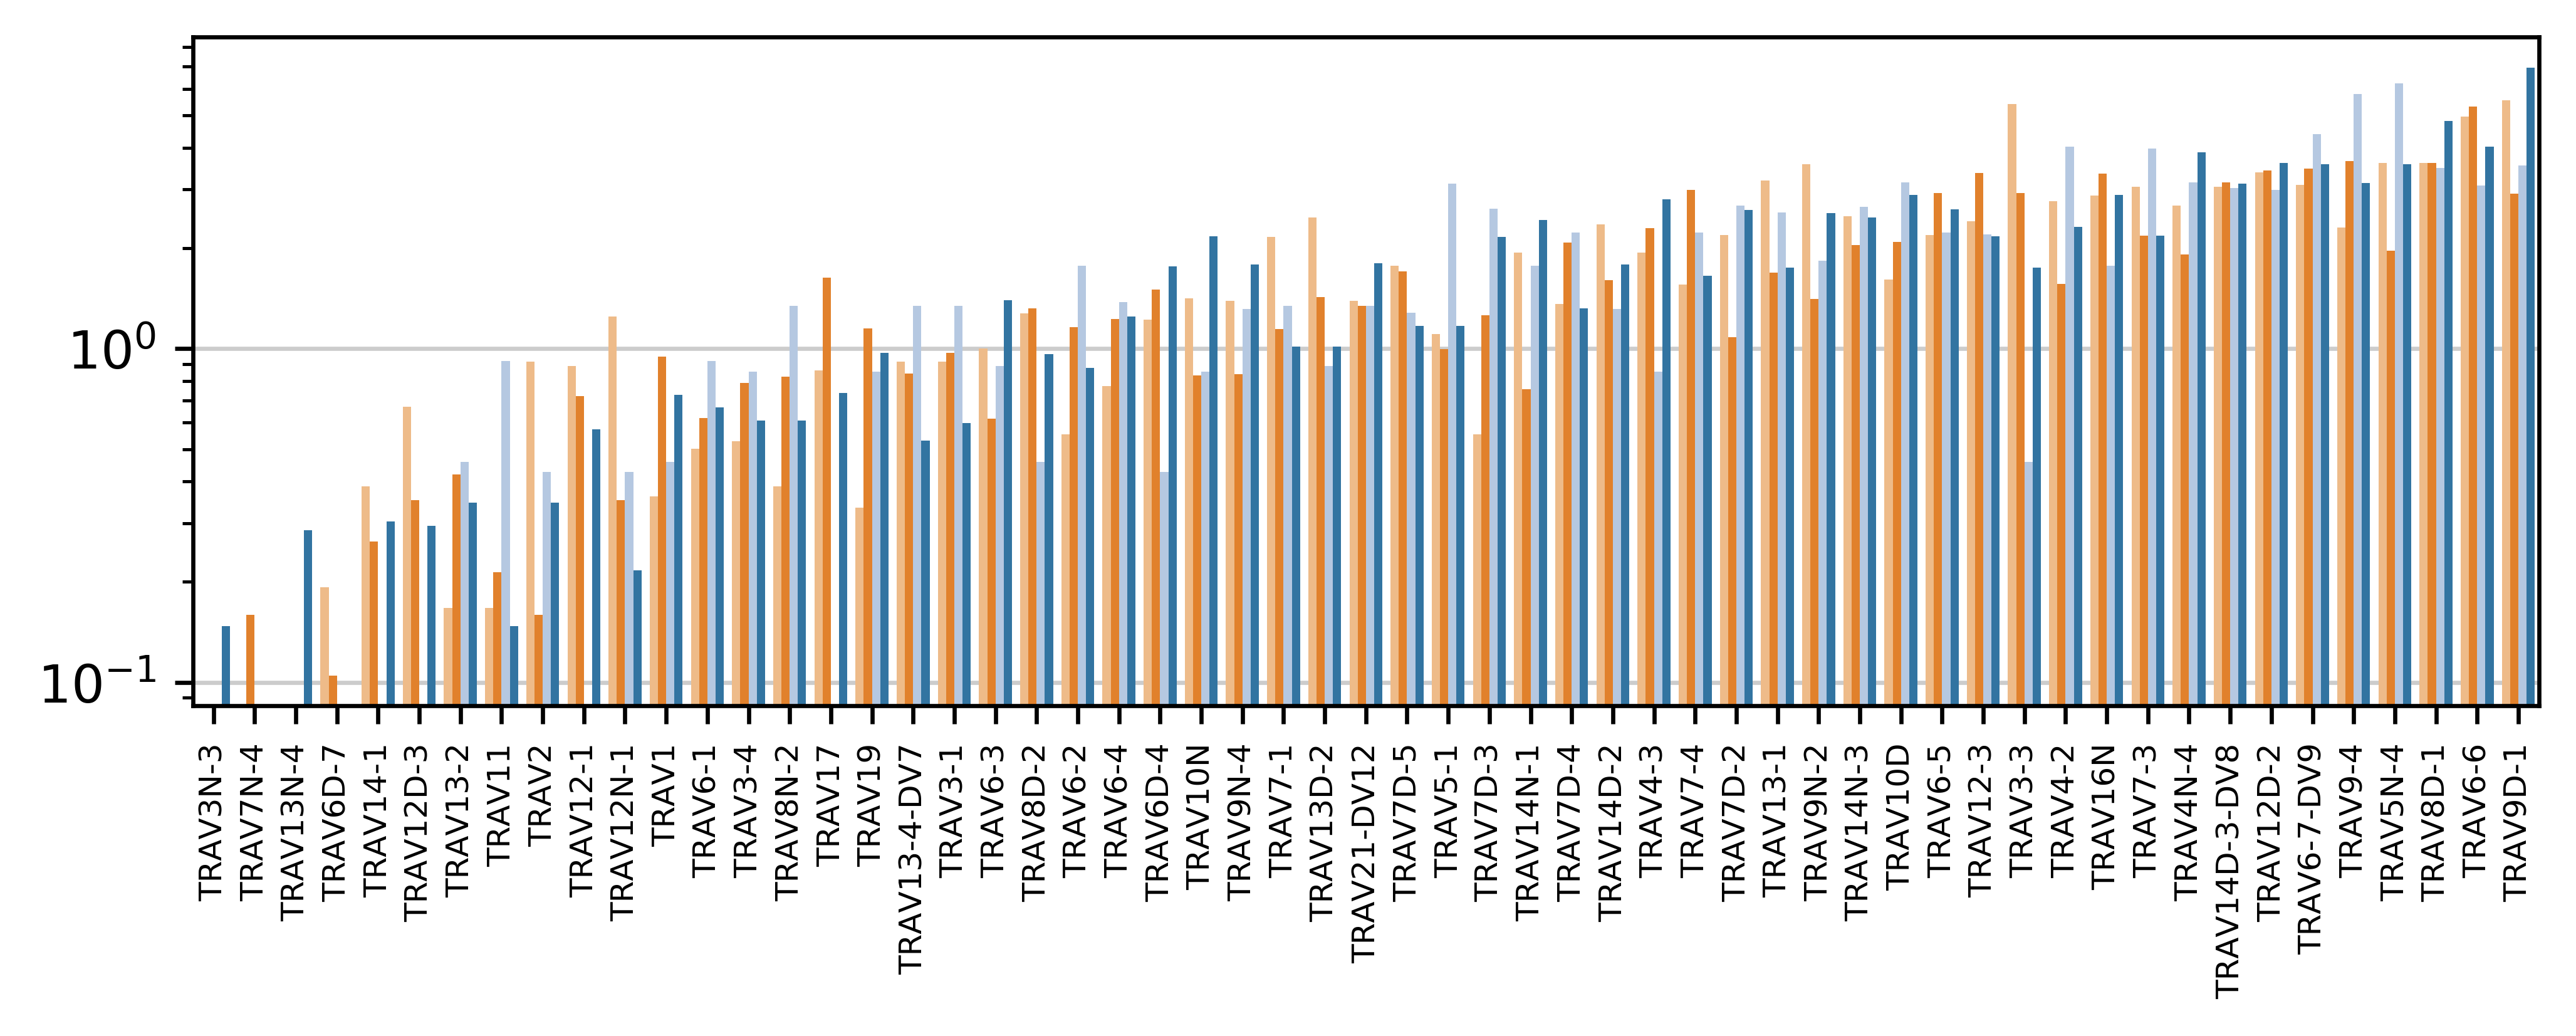

In [77]:
palette = sns.color_palette(["#ffbb78","#ff7f0e","#aec7e8","#1f77b4"])
file_prefix = "/wynton/group/ye/emccarthy/EM/judy_proj/proj_2_mouse_T_cell_001/figures/fig_4/"
df = barplot_grouped_obs_cat(adata_subset_nr4a1_hi, 'TRAV', list(np.unique(adata_subset_nr4a1_hi.obs['TRAV'])), mouse_group_dict , 'batch', ["WT_Low","WT_High","SKG_Low","SKG_High"], palette, gene_order_2, fontsize = 6, x_label = "", y_label = "")#, save_file = True, file_save_prefix = file_prefix, addition = "_nr4a1_cluster", file_format = 'svg')


In [78]:
np.max(adj_p_values[mask])

0.48948279436147957

In [81]:
adj_p_values[mask_nan] = 0.5

In [83]:
color_list = list()
for x,y in zip(adj_p_values, [x[4] for x in list(gene_relative_delta.values())]):
    if x == 0.5:
        color_list = color_list +["#808080"]
    elif x > 0.1:
        color_list = color_list +["#000000"]
    elif y > 0:
        color_list = color_list + ["#1f77b4"]
    
    else:
        color_list = color_list + ["#aec7e8"]

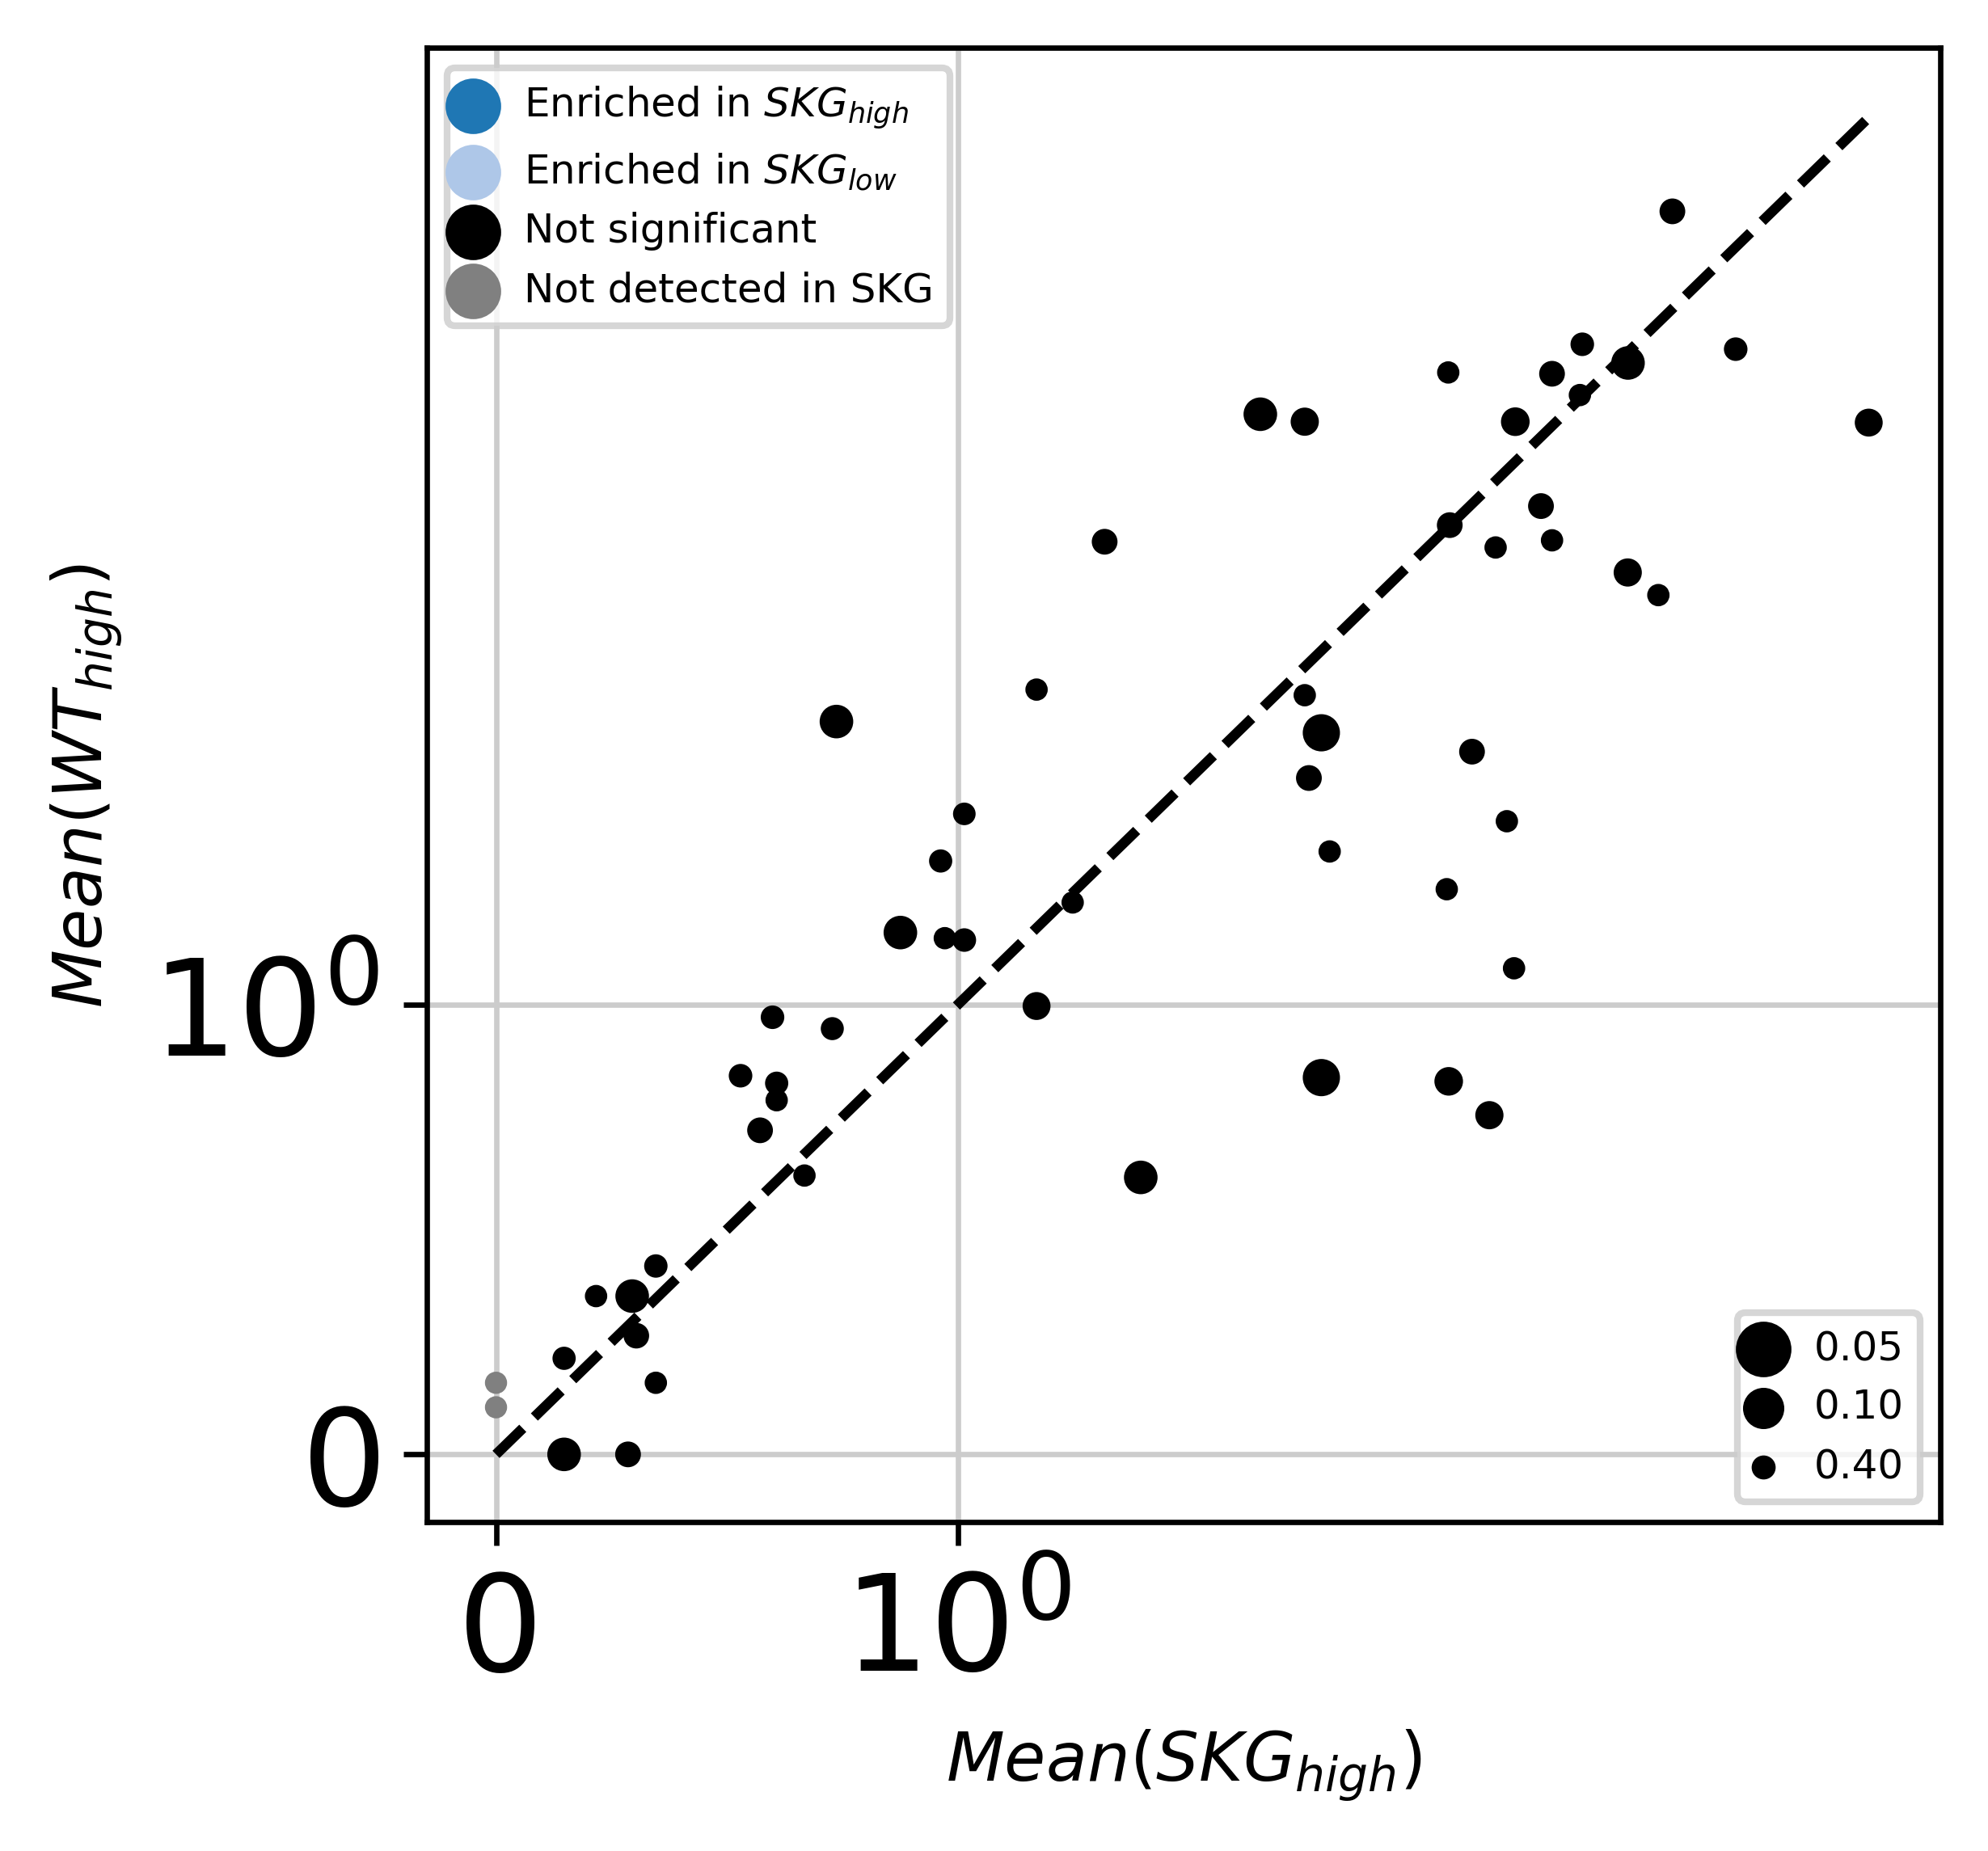

In [84]:
#file_save_prefix = 

plt.rc('axes', axisbelow=True)
extra_value = 20
division_value = 8
plt.scatter([x[1] for x in list(gene_relative_delta.values())], [x[2] for x in list(gene_relative_delta.values())],
            s = [(np.exp(-np.log(x))+extra_value/x)/division_value  for x in adj_p_values], edgecolors=color_list, color =  color_list)


plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel("$Mean(SKG_{high})$", size = 10)
plt.ylabel("$Mean(WT_{high})$", size = 10)

plt.plot([0,7],[0,7], color = 'black', linestyle = '--')
plt.xscale('symlog')
plt.yscale('symlog')


x = [i for i in [x[1] for x in list(gene_relative_delta.values())]]
y = [i for i in [x[2] for x in list(gene_relative_delta.values())]]
p = [i for i in adj_p_values]
labels = list(gene_relative_delta.keys())
bold_dic = {True:"bold", False:"normal"}
p_value_cutoff = 0.1
for i,txt in enumerate(labels):
    if ((p[i] < p_value_cutoff) and (x[i]> y[i] and color_list[i] == "#1f77b4")):
        plt.annotate(txt, (x[i], y[i]), size = 6, weight = "bold")

    elif (p[i] < p_value_cutoff):
        plt.annotate(txt, (x[i], y[i]), size = 6)


l1 = plt.scatter([],[], s=(np.exp(-np.log(0.05))+extra_value/0.05)/division_value, edgecolors="#1f77b4",  color = "#1f77b4")
l2 = plt.scatter([],[], s=(np.exp(-np.log(0.05))+extra_value/0.05)/division_value, edgecolors="#aec7e8",  color = "#aec7e8")
l3 = plt.scatter([],[], s=(np.exp(-np.log(0.05))+extra_value/0.05)/division_value, edgecolors='black',  color = "black")
l4 = plt.scatter([],[], s=(np.exp(-np.log(0.05))+extra_value/0.05)/division_value, edgecolors="#808080",  color = "#808080")
labels = ["Enriched in $SKG_{high}$", "Enriched in $SKG_{low}$", "Not significant", "Not detected in SKG"]

leg = plt.legend([l1, l2, l3,l4], labels, ncol=1, frameon=True, fontsize=6,#handlelength=2, 
                 loc = 2, #borderpad = 1.8,
handletextpad=1, #title='My Title'
                 scatterpoints = 1)

legend_color = 'black'
#l1 = plt.scatter([],[], s=np.exp(-np.log(0.01))+extra_value, edgecolors='black',  color = legend_color)
l1 = plt.scatter([],[], s=(np.exp(-np.log(0.05))+extra_value/0.05)/division_value, edgecolors='black',  color = legend_color)
l2 = plt.scatter([],[], s=(np.exp(-np.log(0.10))+extra_value/0.10)/division_value, edgecolors='black',  color = legend_color)
l3 = plt.scatter([],[], s=(np.exp(-np.log(0.4))+extra_value/0.4)/division_value, edgecolors='black',   color = legend_color)

labels = ["0.05", "0.10", "0.40"]

plt.legend([l1, l2, l3], labels, ncol=1, frameon=True, fontsize=6,#handlelength=2, 
                 loc = 4, #borderpad = 1.8,
handletextpad=1, #title='My Title'
                 scatterpoints = 1)

plt.gca().add_artist(leg)
#plt.savefig(file_save_prefix + "fig_4_TCR_TRA_all_cells_scatterplot_SKG_high_v_WT_high_nr4a1_cluster_030921" + ".svg", format="svg")
plt.show()
plt.close()